# Overview

Optimizing embeddings to boost the accuracy of Retrieval-Augmented Generation(RAG) systems. It covers the fundamentals of embeddings, the benefits of fine-tuning embeddings on domain-specific datasets to enhance relevance.

In [1]:
import os

os.environ['MODEL_NAME']='aisuko/distilroberta-pubmed-embeddings'
os.environ['DATASET_NAME']='aisuko/PubMedQA_instruction_for_FT'
os.environ['WANDB_NAME']='aisuko/PubMedQA_instruction_for_FT'

In [2]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

user_secrets = UserSecretsClient()

login(token=user_secrets.get_secret("HUGGINGFACE_TOKEN"))

In [3]:
from datasets import load_dataset

ds=load_dataset('vblagoje/PubMedQA_instruction')
ds

README.md:   0%|          | 0.00/498 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/274M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/986k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/272458 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 272458
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1000
    })
})

In [4]:
df = ds['train'].to_pandas()
df = df[['instruction', 'context']][:10000]

In [5]:
df

,instruction,context
0,Are group 2 innate lymphoid cells ( ILC2s ) in...,Chronic rhinosinusitis (CRS) is a heterogeneou...
1,Does vagus nerve contribute to the development...,Phosphatidylethanolamine N-methyltransferase (...
2,Does psammaplin A induce Sirtuin 1-dependent a...,Psammaplin A (PsA) is a natural product isolat...
3,Is methylation of the FGFR2 gene associated wi...,This study examined links between DNA methylat...
4,Do tumor-infiltrating immune cell profiles and...,Tumor microenvironment immunity is associated ...
...,...,...
9995,Is effective intra-esophageal acid control ass...,Endoscopic radiofrequency ablation (RFA) is a ...
9996,Does elevated protein kinase C-δ contribute to...,Apoptosis of smooth muscle cells (SMCs) is a p...
9997,Does intersphincteric proctectomy with end-col...,Perianal Crohn's disease (CD) represents a mor...
9998,Is a gene expression profile of stem cell plur...,Understanding the fundamental mechanisms of tu...


# Find the Similarities in the Dataset

In [6]:
import numpy as np
from sentence_transformers import SentenceTransformer


# Load an embedding model
model=SentenceTransformer('all-mpnet-base-v2')
model.to('cuda')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# Compute Sentence Embeddings

In [7]:
# Encode all job descriptions
pubmed_context_embeddings = model.encode(df['context'].to_list())

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [8]:
pubmed_context_embeddings.shape

(10000, 768)

In [9]:
print(len(pubmed_context_embeddings))
print(len(pubmed_context_embeddings[0]))

10000
768


In [10]:
# compute similatiries
similarities=model.similarity(pubmed_context_embeddings, pubmed_context_embeddings)

The similarity function computes the similarity between every pair of embeddings. Since you have 10000 embeddings, it calculates the similarity of each one with all 10000 (including itself), which results in a 10000x10000 matrix. Each entry(i,j) in that matrix represents the similarity between the i-th and j-th embedding. This is why the output shape is torch.Size([10000, 10000]).

In [11]:
similarities.shape

torch.Size([10000, 10000])

Assign each context a negative match(least similar context).

In [12]:
# match least context with least similar to positive match as the negative match

# get sorted indexes of similalities
similarities_argsorted=np.argsort(similarities.numpy(), axis=1)

# initialize list to store negative pairs
negative_pair_index_list = []

for i in range(len(similarities)):

    # start with the smallest similarity index for the current row
    j=0

    index=int(similarities_argsorted[i][j])

    # Ensure the index is unique
    while index in negative_pair_index_list:
        j+=1 # move to the next smallest index
        index=int(similarities_argsorted[i][j]) # fetch next smallest index

    negative_pair_index_list.append(index)

# add negative pairs of df
df['context_neg']=df['context'].iloc[negative_pair_index_list].values

In [13]:
df['context_neg']

0       Velocity propagation (Vp) of early diastole is...
1       Minimal residual disease (MRD) is defined as t...
2       To investigate the effect of initial varus or ...
3       Empyema remains a cause of morbidity and morta...
4       To determine the effect of growth hormone (GH)...
                              ...                        
9995    It is well documented that oxidized low-densit...
9996    Liver injury leads to generation of reactive o...
9997    Non-alcoholic steatohepatitis (NASH) is a subs...
9998    Sweroside is an iridoid glycoside with diverse...
9999    The peptidyl-proline isomerase, Protein Never ...
Name: context_neg, Length: 10000, dtype: object

# Prepare the dataset for our finetuning

In [14]:
from datasets import DatasetDict, Dataset


# shuffle the dataset
df=df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into train, validation, and test sets
train_frac=0.1
valid_frac=0.1
test_frac=0.1

# define train and validation size
train_size=int(train_frac * len(df))
valid_size=int(valid_frac * len(df))


# create train, validation and test datasets
df_train=df[:train_size]
df_valid=df[train_size:train_size+valid_size]
df_test=df[train_size+valid_size:]


# convert the pandas DataFrames back to Hugging Face Datasets
train_ds=Dataset.from_pandas(df_train)
valid_ds=Dataset.from_pandas(df_valid)
test_ds=Dataset.from_pandas(df_test)

# combine into a datasetdict
dataset_dict=DatasetDict({
    'train': train_ds,
    'validation': valid_ds,
    'test': test_ds
})

dataset_name=os.getenv('DATASET_NAME')

# push data to hub
# dataset_dict.push_to_hub(dataset_name)

In [15]:
dataset_dict.push_to_hub(dataset_name)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/576 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/aisuko/PubMedQA_instruction_for_FT/commit/5ab7193d64563ea84535e685da28b884b1dbb16a', commit_message='Upload dataset', commit_description='', oid='5ab7193d64563ea84535e685da28b884b1dbb16a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/aisuko/PubMedQA_instruction_for_FT', endpoint='https://huggingface.co', repo_type='dataset', repo_id='aisuko/PubMedQA_instruction_for_FT'), pr_revision=None, pr_num=None)

# Evaluate Model Using Triplet Loss

Common loss funtions used for embedding models include contrastive loss, triplet loss and cross-entropy loss, depending on the specific task. 

For example, **contrastive loss** helps in learning similar and dissimilar pairs, while triplet loss ensures that embeddings of similar items remain close while pushing dissimilar ones apart.

In [16]:
import gc
import torch
from sentence_transformers.evaluation import TripletEvaluator

model_name='sentence-transformers/all-distilroberta-v1'

del model

gc.collect()

torch.cuda.empty_cache()

model=SentenceTransformer(model_name)
model.to('cuda')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

## Checks Ranking Quality

In [17]:
evaluator_valid=TripletEvaluator(
    anchors=dataset_dict['validation']['instruction'],
    positives=dataset_dict['validation']['context'],
    negatives=dataset_dict['validation']['context_neg'],
    name='ai-pubmbed-validation',
)

evaluator_valid(model)

{'ai-pubmbed-validation_cosine_accuracy': 1.0}

# Using Multiple Negatives Ranking Loss with a Pre-trained Model

In [18]:
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers import SentenceTransformerTrainingArguments
from sentence_transformers import SentenceTransformerTrainer


loss=MultipleNegativesRankingLoss(model)


train_args=SentenceTransformerTrainingArguments(
    output_dir=os.getenv('MODEL_NAME'),
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    batch_sampler='no_duplicates', # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    eval_strategy='steps',
    eval_steps=100,
    logging_steps=100,
    report_to="tensorboard",
    run_name=os.getenv('WANDB_NAME')
)

trainer = SentenceTransformerTrainer(
    model=model,
    args=train_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    loss=loss,
    evaluator=evaluator_valid,
)
trainer.train()

Step,Training Loss,Validation Loss


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

TrainOutput(global_step=63, training_loss=0.006843310499948169, metrics={'train_runtime': 56.5437, 'train_samples_per_second': 17.685, 'train_steps_per_second': 1.114, 'total_flos': 0.0, 'train_loss': 0.006843310499948169, 'epoch': 1.0})

# Validate the Newly Created Model

In [19]:
trainer.push_to_hub()

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1741517539.179dd39c1444.18.0:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.62k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aisuko/distilroberta-pubmed-embeddings/commit/e0ffa82b3f923cde3911821bf49b15551c8218a9', commit_message='End of training', commit_description='', oid='e0ffa82b3f923cde3911821bf49b15551c8218a9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/aisuko/distilroberta-pubmed-embeddings', endpoint='https://huggingface.co', repo_type='model', repo_id='aisuko/distilroberta-pubmed-embeddings'), pr_revision=None, pr_num=None)

In [20]:
model=SentenceTransformer(os.getenv('MODEL_NAME'))
model.to('cuda')

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [21]:
# new query
query = "Does age significantly influence how growth hormone responds to brief, high-intensity exercise among healthy young men of normal weight?"
query_embedding = model.encode(query)

# encode context
test_pubmed__embeddings = model.encode(dataset_dict["test"]["context"])

# compute similarities
similarities = model.similarity(query_embedding, test_pubmed__embeddings)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

In [22]:
similarities.shape

torch.Size([1, 8000])

In [23]:
import torch

similarities_np=similarities.numpy().flatten()

Text(0, 0.5, 'Feature Value')

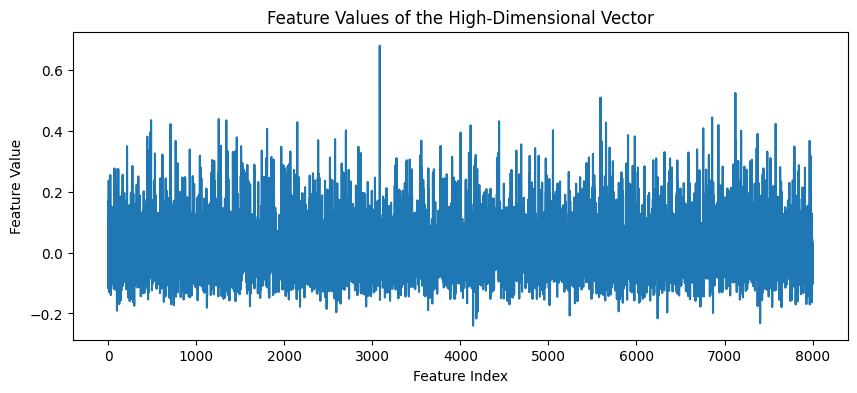

In [24]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))
plt.plot(similarities_np)
plt.title('Feature Values of the High-Dimensional Vector')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')

# Acknowledgment

* https://medium.com/gopenai/boosting-rag-accuracy-part1-the-role-of-fine-tuning-an-embedding-model-for-domain-knowledge-279261b1bb22